In [1]:
import pandas as pd
import sys
sys.path.append("/home/calvin/code/cmpnn_revised")
from pathlib import Path

In [2]:
from cmpnn.featurizer.molecule_dataset import MoleculeDataset
from cmpnn.featurizer.atom_bond import AtomFeaturizer, BondFeaturizer
from cmpnn.models.lightning import CMPNNLightningModuleTimed, CMPNNLightningModule
from cmpnn.optimizer.noam import NoamLikeOptimizer
from cmpnn.featurizer.utils import featurize_molecule
from cmpnn.data.collate import mol_collate_fn
from torch.utils.data import DataLoader
from cmpnn.split.crossvalidator import CrossValidator
import torch
from torch.utils.data import random_split
from cmpnn.split.scaffold import ScaffoldSplitter
import logging
from cmpnn.split.utils import log_scaffold_stats, plot_split_distributions
import pytorch_lightning as pl

In [3]:
cmpnn_dir = Path.cwd().parent
csv_file = cmpnn_dir/"cmpnn"/ "mol_data" / "freesolv.csv"

In [4]:
dataset = MoleculeDataset(
    csv_file=csv_file,
    atom_featurizer=AtomFeaturizer(v2=False),
    bond_featurizer=BondFeaturizer(),
    smiles_col="smiles",
    target_cols=["freesolv"],
    use_cache=False,
    atom_messages=False
)

Using all atomic numbers from 1 to 100
Processing data from /home/calvin/code/cmpnn_revised/cmpnn/mol_data/freesolv.csv


In [5]:
# When doing 'atom_messages=False', the dataset will return f_atoms + f_bonds -> 147
dataset[61].f_bonds.shape

torch.Size([1, 147])

# Prepare for Cross Validator + Scaffold

In [6]:
# First we select a random subset of the dataset to be the test set
# We intend to use 10% of the dataset as the test set
total_len = len(dataset)
test_len = int(total_len * 0.1)
train_val_len = total_len - test_len

# Now we randomly split the test dataset out of the full dataset
train_val_data, test_data = random_split(dataset, [train_val_len, test_len], generator=torch.Generator().manual_seed(42))

# We instantiate the scaffold splitter
scaff_splitter = ScaffoldSplitter(seed=42)


In [7]:
# Before we split the train_val_data, we can look at the distribution
logging.basicConfig(level=logging.INFO)

train_idx, val_idx = scaff_splitter.split(
    train_val_data,
    train_frac=0.9,
    test_frac=0.1,
    return_indices=True,
)


log = log_scaffold_stats(
    data=dataset,
    index_sets=[set(train_idx), set(val_idx)],
    num_scaffolds=2,
    num_labels=1,
    logger=logging.getLogger("scaffold")
)

INFO:scaffold:Label mean/std/count per split (max 2 splits, 1 labels):
INFO:scaffold:Split 0: mean=[-3.8890383], std=[3.9271374], count=[520]
INFO:scaffold:Split 1: mean=[-3.4227586], std=[3.0821638], count=[58]


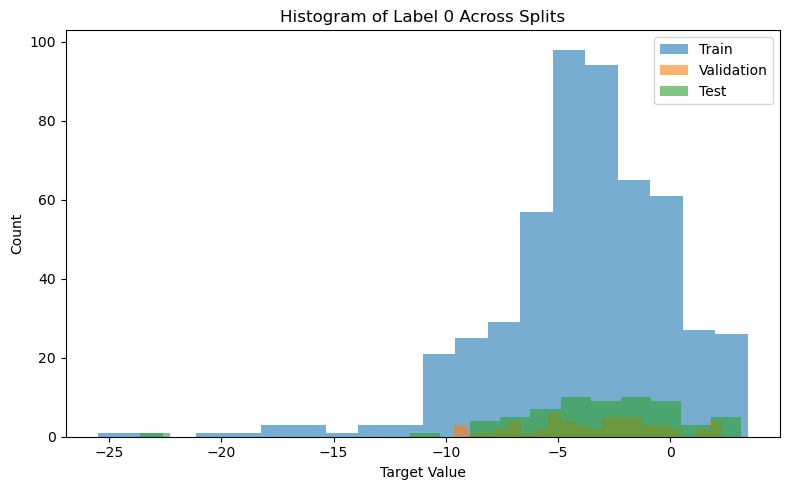

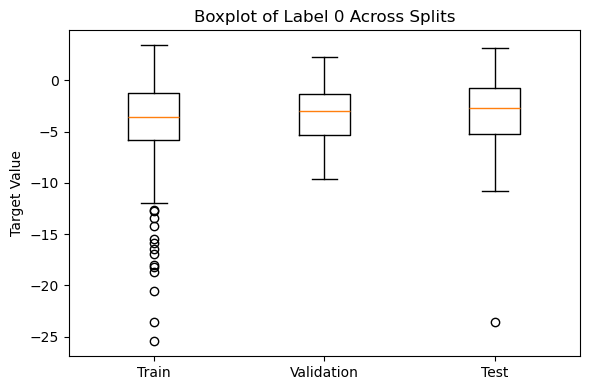

In [8]:
plot_split_distributions(
    dataset=dataset,
    index_sets=[set(train_idx),set(val_idx), set(test_data.indices)],
    label_index=0
)

# Model Setup

In [17]:
model = lambda: CMPNNLightningModule(
    atom_fdim=133,
    bond_fdim=147,
    atom_messages=False,
    global_fdim=0,
    hidden_dim=512,
    booster="sum",
    comm_mode="add",
    optimizer_class=NoamLikeOptimizer,
    optimizer_params={
        'init_lr': 1e-4,
        'max_lr': 1e-3,
        'final_lr': 1e-5,
        'warmup_steps': 1000,
        'total_steps': 10000,
    }
)


# Setup Trainer - Pytorch Lightning

In [14]:
trainer_fn = lambda: pl.Trainer(
    max_epochs=50,
    accelerator="gpu",
    devices=1,
    enable_progress_bar=True,
    logger=None,
    enable_checkpointing=False,
    log_every_n_steps=10,
)

In [15]:
cross_val = CrossValidator(
    dataset=train_val_data,
    model_fn=model,
    trainer_fn=trainer_fn,
    splitter=scaff_splitter,
    k=5,
    test_set=test_data)

In [16]:
cross_val.run()

Running Fold 1/5


TypeError: CMPNNLightningModule.forward() missing 6 required positional arguments: 'f_atoms', 'f_bonds', 'a2b', 'b2a', 'b2revb', and 'a_scope'

In [13]:
model = model()
trainer = trainer_fn()

full_loader = DataLoader(train_val_data, batch_size=32, collate_fn=mol_collate_fn)
test_loader = DataLoader(test_data, batch_size=32, collate_fn=mol_collate_fn)

trainer.fit(model, full_loader)
trainer.test(model, test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type           | Params | Mode 
------------------------------------------------------
0 | model      | CMPNNEncoder   | 5.1 M  | train
1 | aggregator | MeanAggregator | 0      | train
2 | bn         | Identity       | 0      | train
3 | ffn        | MLP            | 263 K  | train
4 | metrics    | ModuleDict     | 0      | train
------------------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.576    Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            MAE            │     2.369612693786621     │
│            R2             │    0.17539459466934204    │
│           RMSE            │    3.6116652488708496     │
└───────────────────────────┴───────────────────────────┘

[{'RMSE': 3.6116652488708496,
  'MAE': 2.369612693786621,
  'R2': 0.17539459466934204}]